In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/c4200m/C4_200M.tsv-00003-of-00010
/kaggle/input/c4200m/C4_200M.tsv-00004-of-00010
/kaggle/input/c4200m/C4_200M.tsv-00002-of-00010
/kaggle/input/c4200m/C4_200M.tsv-00001-of-00010
/kaggle/input/c4200m/C4_200M.tsv-00009-of-00010
/kaggle/input/c4200m/C4_200M.tsv-00006-of-00010
/kaggle/input/c4200m/C4_200M.tsv-00000-of-00010
/kaggle/input/c4200m/C4_200M.tsv-00005-of-00010
/kaggle/input/c4200m/C4_200M.tsv-00007-of-00010
/kaggle/input/c4200m/C4_200M.tsv-00008-of-00010
/kaggle/input/custom_gec_model/pytorch/default/1/config.json
/kaggle/input/custom_gec_model/pytorch/default/1/spiece.model
/kaggle/input/custom_gec_model/pytorch/default/1/training_args.bin
/kaggle/input/custom_gec_model/pytorch/default/1/tokenizer_config.json
/kaggle/input/custom_gec_model/pytorch/default/1/model.safetensors
/kaggle/input/custom_gec_model/pytorch/default/1/special_tokens_map.json
/kaggle/input/custom_gec_model/pytorch/default/1/added_tokens.json
/kaggle/input/custom_gec_model/pytorch/default/1/gen

In [5]:
import pandas as pd
from datasets import Dataset,DatasetDict,concatenate_datasets
from datasets import load_dataset
from transformers import AutoTokenizer
import torch
from tqdm import tqdm
from transformers import T5ForConditionalGeneration, T5Tokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
from datasets import load_dataset, DatasetDict
from transformers import T5Tokenizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

device = torch.device('cuda')
os.environ["WANDB_DISABLED"] = "true"

In [6]:
dataset = load_dataset("grammarly/coedit")

README.md:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/19.7M [00:00<?, ?B/s]

validation.jsonl:   0%|          | 0.00/692k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/69071 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1712 [00:00<?, ? examples/s]

In [7]:
df = pd.read_csv("/kaggle/input/c4200m/C4_200M.tsv-00000-of-00010",index_col=False, delimiter='\t' , nrows=100000)
df.columns = ["src", "tgt"]
df.shape

(100000, 2)

In [8]:
start_id = 69072
df['_id'] = str(range(start_id, start_id + len(df)))
df['task'] = 'gec'

In [9]:
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

train_dataset = Dataset.from_pandas(train_df,preserve_index=False)
test_dataset = Dataset.from_pandas(test_df,preserve_index=False)

In [10]:
combined_dataset = DatasetDict({
    "train": concatenate_datasets([dataset["train"], train_dataset]).shuffle(seed=42),
    "validation": concatenate_datasets([dataset["validation"], test_dataset]).shuffle(seed=42)
})

In [11]:
tasks = combined_dataset["train"].unique("task")

In [12]:
combined_dataset["validation"][0]

{'_id': 'range(69072, 169072)',
 'task': 'gec',
 'src': 'How long does it take to complete the Introduction to Feline Care Certification coruse.',
 'tgt': 'How long does it take to complete the Introduction to Feline Care Certification course?'}

In [13]:
tasks

['gec', 'neutralize', 'simplification', 'paraphrase', 'coherence', 'clarity']

In [14]:


# Initialize the tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

# Filter for grammatical error correction tasks
# gec_dataset = combined_dataset.filter(lambda x: x['task'] == 'gec')

# Tokenization function
def tokenize_function(batch):
    inputs = batch['src']
    targets = batch['tgt']
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenize the dataset
tokenized_dataset = combined_dataset.map(tokenize_function, batched=True, remove_columns=['_id', 'task', 'src', 'tgt'])


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/149071 [00:00<?, ? examples/s]

Map:   0%|          | 0/21712 [00:00<?, ? examples/s]

In [15]:


# Create separate datasets for each task
filtered_datasets = DatasetDict({task: combined_dataset["train"].filter(lambda x: x["task"] == task) for task in tasks})



tokenized_filtered_dataset = filtered_datasets.map(tokenize_function, batched=True, remove_columns=['_id', 'task', 'src', 'tgt'])

Filter:   0%|          | 0/149071 [00:00<?, ? examples/s]

Filter:   0%|          | 0/149071 [00:00<?, ? examples/s]

Filter:   0%|          | 0/149071 [00:00<?, ? examples/s]

Filter:   0%|          | 0/149071 [00:00<?, ? examples/s]

Filter:   0%|          | 0/149071 [00:00<?, ? examples/s]

Filter:   0%|          | 0/149071 [00:00<?, ? examples/s]

Map:   0%|          | 0/99823 [00:00<?, ? examples/s]

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

Map:   0%|          | 0/11440 [00:00<?, ? examples/s]

Map:   0%|          | 0/15370 [00:00<?, ? examples/s]

Map:   0%|          | 0/10616 [00:00<?, ? examples/s]

Map:   0%|          | 0/1252 [00:00<?, ? examples/s]

In [16]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 149071
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 21712
    })
})

In [17]:
tokenized_filtered_dataset

DatasetDict({
    gec: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 99823
    })
    neutralize: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10570
    })
    simplification: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 11440
    })
    paraphrase: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 15370
    })
    coherence: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10616
    })
    clarity: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1252
    })
})

In [18]:


# Load the model
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./coedit_gec_model",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=5,
    predict_with_generate=True,
    logging_dir="./logs",
    logging_steps=500,
    report_to=None
)

# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Initialize the trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
)


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


NameError: name 'tokenized_dataset' is not defined

In [32]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [35]:

# tokenized_dataset['validation'][0]

In [21]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.178300,0.185741
2,0.176200,0.181172
3,0.167000,0.178676
4,0.163400,0.178707
5,0.162600,0.177514


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=46585, training_loss=0.1783375368796923, metrics={'train_runtime': 11425.633, 'train_samples_per_second': 65.235, 'train_steps_per_second': 4.077, 'total_flos': 2.521942210904064e+16, 'train_loss': 0.1783375368796923, 'epoch': 5.0})

In [22]:
trainer.save_model("./coedit_gec_model")


In [23]:
import shutil

# Compress the saved model directory into a .zip file
shutil.make_archive("/kaggle/working/coedit_gec_model", 'zip', "./coedit_gec_model")


'/kaggle/working/coedit_gec_model.zip'

In [24]:
# Now you can manually download the file from the Kaggle UI by clicking the download button on the zip file
shutil.move("/kaggle/working/coedit_gec_model.zip", "/kaggle/working/coedit_gec_model.zip")


'/kaggle/working/coedit_gec_model.zip'

In [18]:
import evaluate
import numpy as np


model_path = "/kaggle/input/custom_gec_model/pytorch/default/1"
model = T5ForConditionalGeneration.from_pretrained(model_path)

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./coedit_gec_model",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=5,
    predict_with_generate=True,
    logging_dir="./logs",
    logging_steps=500,
    report_to=None
)

# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Initialize the trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
)


# Load evaluation metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

# Function to compute metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute BLEU
    bleu_score = bleu.compute(predictions=decoded_preds, references=[[label] for label in decoded_labels])

    # Compute ROUGE
    rouge_score = rouge.compute(predictions=decoded_preds, references=decoded_labels)

    return {
        "bleu": bleu_score['bleu'],
        "rouge1": rouge_score['rouge1'],
        "rouge2": rouge_score['rouge2'],
        "rougeL": rouge_score['rougeL'],
        "rougeLsum": rouge_score['rougeLsum'],
    }

# Update the trainer to include the compute_metrics function
trainer.compute_metrics = compute_metrics

# Evaluate the model
# results = trainer.evaluate()
# print(results)


ModuleNotFoundError: No module named 'evaluate'

In [19]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load the trained model and tokenizer
model_path = "/kaggle/input/custom_gec_model/pytorch/default/1"
model = T5ForConditionalGeneration.from_pretrained(model_path)
tokenizer = T5Tokenizer.from_pretrained(model_path)


def correct_grammar(input_text):
    # Preprocess the input text by adding the "fix: " prefix (for grammar correction task)
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    
    # Generate the corrected output
    output_tokens = model.generate(**inputs, max_length=128)
    
    # Decode the output tokens back to text
    corrected_text = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
    
    return corrected_text

In [20]:
incorrect_sentence = "correct the scentence: I want to study today with I want to study tommorow for the exams."
corrected_sentence = correct_grammar(incorrect_sentence)

print("Original:", incorrect_sentence)
print("Corrected:", corrected_sentence)

Original: correct the scentence: I want to study today with I want to study tommorow for the exams.
Corrected: I want to study today with I want to study tommorow for the exams.


In [28]:
import evaluate
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load the evaluation metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

# Load the trained model and tokenizer
model_path = "/kaggle/input/custom_gec_model/pytorch/default/1"
model = T5ForConditionalGeneration.from_pretrained(model_path)
tokenizer = T5Tokenizer.from_pretrained(model_path)

# Ensure the model is in evaluation mode
model.eval()


T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [29]:
filtered_datasets_1k = DatasetDict({
    task: dataset.select(range(min(len(dataset), 1000))) if len(dataset) > 0 else dataset
    for task, dataset in filtered_datasets.items()
})

In [30]:
for task, dataset in filtered_datasets_1k.items():
    print(f"{task}: {len(dataset)} samples")

gec: 1000 samples
neutralize: 1000 samples
simplification: 1000 samples
paraphrase: 1000 samples
coherence: 1000 samples
clarity: 1000 samples


In [31]:



def evaluate_model(test_texts, reference_texts):
    """
    Evaluate the model using BLEU and ROUGE scores.

    Args:
        test_texts (list): List of input texts for evaluation.
        reference_texts (list): Corresponding list of reference corrected texts.

    Returns:
        dict: Computed BLEU and ROUGE scores.
    """
    predictions = []

    for text in tqdm(test_texts):
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
        
        with torch.no_grad():
            output_tokens = model.generate(**inputs, max_length=128)
        
        corrected_text = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
        predictions.append(corrected_text)

    # Compute BLEU
    bleu_score = bleu.compute(predictions=predictions, references=[[ref] for ref in reference_texts])

    # Compute ROUGE
    rouge_score = rouge.compute(predictions=predictions, references=reference_texts)

    return {
        "bleu": bleu_score['bleu'],
        "rouge1": rouge_score['rouge1'],
        "rouge2": rouge_score['rouge2'],
        "rougeL": rouge_score['rougeL'],
        "rougeLsum": rouge_score['rougeLsum'],
    }

# Example usage

results = []
for i,task in enumerate(filtered_datasets_1k):
    test_samples = filtered_datasets_1k[task]['src']
    reference_samples = filtered_datasets_1k[task]['tgt']
    scores = evaluate_model(test_samples, reference_samples)
    results.append(scores)

test_samples = ["This is a example sentence?", "She go to school every day?"]
reference_samples = ["This is an example sentence.", "She goes to school every day."]


print(results)


100%|██████████| 1000/1000 [13:37<00:00,  1.22it/s]


[{'bleu': 0.7175104915687778, 'rouge1': 0.8773515346046941, 'rouge2': 0.7658094747500159, 'rougeL': 0.8708006373303652, 'rougeLsum': 0.8708550534182578}, {'bleu': 0.8587214324755853, 'rouge1': 0.9333788185907412, 'rouge2': 0.8724009078660295, 'rougeL': 0.9332478649358051, 'rougeLsum': 0.9334602361769371}, {'bleu': 0.28075102164939975, 'rouge1': 0.6285538050969599, 'rouge2': 0.39552732322597717, 'rougeL': 0.5609971251892132, 'rougeLsum': 0.5606610753128753}, {'bleu': 0.14956152121289715, 'rouge1': 0.4647306749995037, 'rouge2': 0.20534886353190085, 'rougeL': 0.397853433759355, 'rougeLsum': 0.398100220235029}, {'bleu': 0.8882039664055792, 'rouge1': 0.9576422248059773, 'rouge2': 0.9158075933845347, 'rougeL': 0.9492787110826827, 'rougeLsum': 0.9494212277459589}, {'bleu': 0.7595611066469834, 'rouge1': 0.863066549250389, 'rouge2': 0.7922987257501984, 'rougeL': 0.854168095286105, 'rougeLsum': 0.8540500848860847}]


In [ ]:
alltask_results = [{'bleu': 0.7175104915687778, 'rouge1': 0.8773515346046941, 'rouge2': 0.7658094747500159, 'rougeL': 0.8708006373303652, 'rougeLsum': 0.8708550534182578}, {'bleu': 0.8587214324755853, 'rouge1': 0.9333788185907412, 'rouge2': 0.8724009078660295, 'rougeL': 0.9332478649358051, 'rougeLsum': 0.9334602361769371}, {'bleu': 0.28075102164939975, 'rouge1': 0.6285538050969599, 'rouge2': 0.39552732322597717, 'rougeL': 0.5609971251892132, 'rougeLsum': 0.5606610753128753}, {'bleu': 0.14956152121289715, 'rouge1': 0.4647306749995037, 'rouge2': 0.20534886353190085, 'rougeL': 0.397853433759355, 'rougeLsum': 0.398100220235029}, {'bleu': 0.8882039664055792, 'rouge1': 0.9576422248059773, 'rouge2': 0.9158075933845347, 'rougeL': 0.9492787110826827, 'rougeLsum': 0.9494212277459589}, {'bleu': 0.7595611066469834, 'rouge1': 0.863066549250389, 'rouge2': 0.7922987257501984, 'rougeL': 0.854168095286105, 'rougeLsum': 0.8540500848860847}]

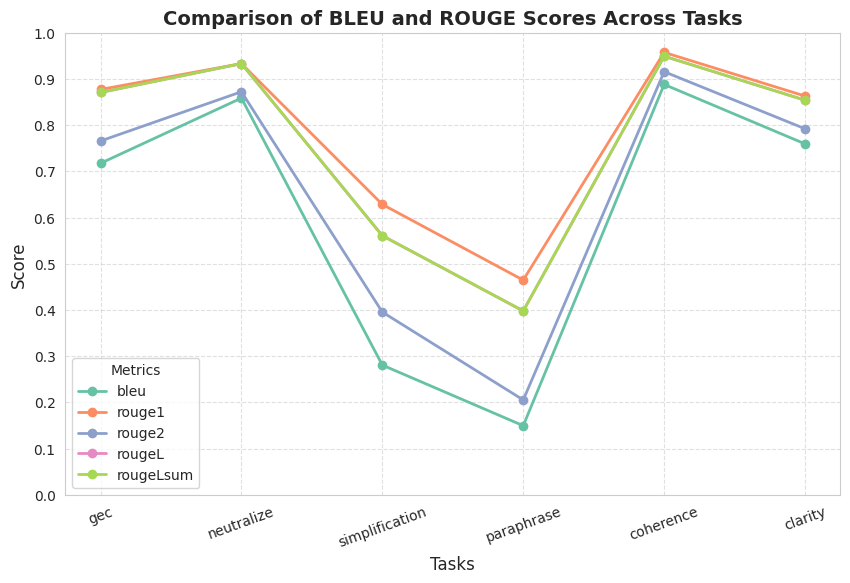

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data
tasks = ['gec', 'neutralize', 'simplification', 'paraphrase', 'coherence', 'clarity']
metrics = ['bleu', 'rouge1', 'rouge2', 'rougeL', 'rougeLsum']

scores = alltask_results = [
    {'bleu': 0.7175104915687778, 'rouge1': 0.8773515346046941, 'rouge2': 0.7658094747500159, 'rougeL': 0.8708006373303652, 'rougeLsum': 0.8708550534182578}, 
    {'bleu': 0.8587214324755853, 'rouge1': 0.9333788185907412, 'rouge2': 0.8724009078660295, 'rougeL': 0.9332478649358051, 'rougeLsum': 0.9334602361769371}, 
    {'bleu': 0.28075102164939975, 'rouge1': 0.6285538050969599, 'rouge2': 0.39552732322597717, 'rougeL': 0.5609971251892132, 'rougeLsum': 0.5606610753128753}, 
    {'bleu': 0.14956152121289715, 'rouge1': 0.4647306749995037, 'rouge2': 0.20534886353190085, 'rougeL': 0.397853433759355, 'rougeLsum': 0.398100220235029}, 
    {'bleu': 0.8882039664055792, 'rouge1': 0.9576422248059773, 'rouge2': 0.9158075933845347, 'rougeL': 0.9492787110826827, 'rougeLsum': 0.9494212277459589}, 
    {'bleu': 0.7595611066469834, 'rouge1': 0.863066549250389, 'rouge2': 0.7922987257501984, 'rougeL': 0.854168095286105, 'rougeLsum': 0.8540500848860847}
]

# Convert data to NumPy array for easy plotting
data_matrix = np.array([[task_scores[metric] for task_scores in scores] for metric in metrics])

# Set Seaborn style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Define colors
colors = sns.color_palette("Set2", len(metrics))

# Plot each metric
for i, metric in enumerate(metrics):
    plt.plot(tasks, data_matrix[i], marker='o', linestyle='-', color=colors[i], label=metric, linewidth=2)

# Labels and title
plt.xlabel("Tasks", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Comparison of BLEU and ROUGE Scores Across Tasks", fontsize=14, fontweight='bold')

# Improve readability
plt.xticks(rotation=20)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0, 1)
plt.legend(title="Metrics", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()



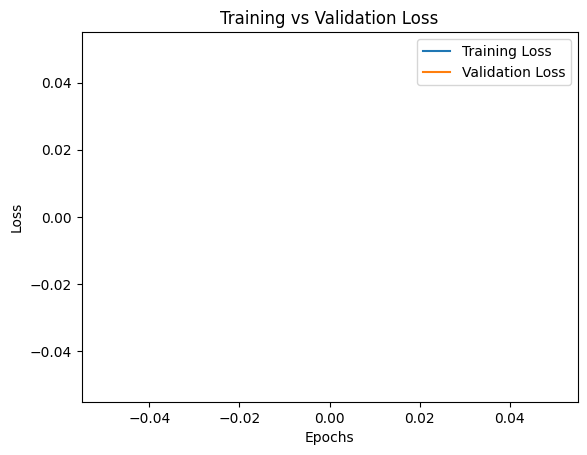

In [25]:
# Assuming Trainer saves logs in history
history = trainer.state.log_history
train_loss = [entry["loss"] for entry in history if "loss" in entry]
eval_loss = [entry["eval_loss"] for entry in history if "eval_loss" in entry]

plt.plot(train_loss, label="Training Loss")
plt.plot(eval_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


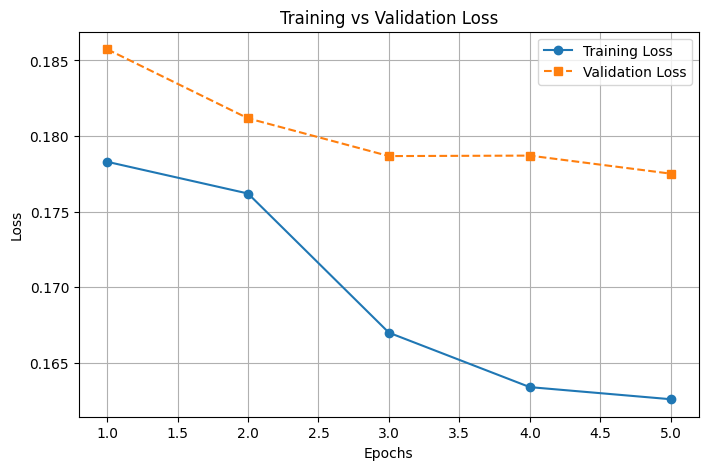

In [15]:
import matplotlib.pyplot as plt

# Data: Loss values from training and validation
epochs = [1, 2, 3, 4, 5]
train_loss = [0.178300, 0.176200, 0.167000, 0.163400, 0.162600]
val_loss = [0.185741, 0.181172, 0.178676, 0.178707, 0.177514]

# Plot the loss curves
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, marker='o', linestyle='-', label='Training Loss')
plt.plot(epochs, val_loss, marker='s', linestyle='--', label='Validation Loss')

# Labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [16]:
import matplotlib.pyplot as plt

# Extract training and validation loss along with their epochs
train_loss = [(entry["epoch"], entry["loss"]) for entry in history if "loss" in entry]
eval_loss = [(entry["epoch"], entry["eval_loss"]) for entry in history if "eval_loss" in entry]

# Convert lists into separate epoch and loss lists
train_epochs, train_loss_values = zip(*train_loss) if train_loss else ([], [])
eval_epochs, eval_loss_values = zip(*eval_loss) if eval_loss else ([], [])

# Find the last 5 unique epochs
last_epochs = sorted(set(eval_epochs))[-5:]  # Get only the last 5 unique epochs

# Filter losses to include only data from the last 5 epochs
filtered_train_loss = [loss for epoch, loss in zip(train_epochs, train_loss_values) if epoch in last_epochs]
filtered_eval_loss = [loss for epoch, loss in zip(eval_epochs, eval_loss_values) if epoch in last_epochs]

# Plot the filtered losses
plt.figure(figsize=(8,5))
plt.plot(last_epochs, filtered_train_loss, label="Training Loss", marker="o")
plt.plot(last_epochs, filtered_eval_loss, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss (Last 5 Epochs)")
plt.grid()
plt.show()

NameError: name 'history' is not defined

In [22]:
!pip install rouge_score
!pip install evaluate

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=990fb9ddfd15913f632ee4c89e5c118e2eeb2f2c69a9c4490b1484fb641461d5
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.1 MB/s eta 0:00:00
